# Assignment 2

The idea behind assignment 2 is to build an ML model that recognizes emotions from images (sad face, happy, surprised, etc.). In order to achieve this, we will train the FER 2013 dataset that can befound in Kaggle (https://www.kaggle.com/datasets/purnisharma/fer2013). This version of FER 2013 stores all the images and labels for the three splits in a single .csv file. The very first step is to split this into the three sets so that we avoid data leakages between the training, private test and public test sets.

The training set will be used for training. You will try to improve the performance by measuring on the private test set and to make your final validation in the public test set.


In [1]:
import pandas as pd
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load the dataset
df = pd.read_csv("fer2013.csv") # Add here the path to your fer2013.csv file

###################################################################
# Separating the dataset between train, test, and validation sets
###################################################################
# The dataset already contains the splits which are specified in the 
# "Usage" field
print( df['Usage'].value_counts() )

# We use for training and validation the "Training" and "PublicTest"
trai_df = df[df['Usage']== 'Training'].copy()
vali_df = df[df['Usage'] == 'PublicTest'].copy()
test_df = df[df['Usage'] == 'PrivateTest'].copy() 

# Storing train and test data frames
trai_df.to_csv("./data/fer2013_train.csv", encoding='utf-8', index=False)
vali_df.to_csv("./data/fer2013_validation.csv", encoding='utf-8', index=False)
test_df.to_csv("./data/fer2013_test.csv", encoding='utf-8', index=False)

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


Now we compute the class weights for the training set

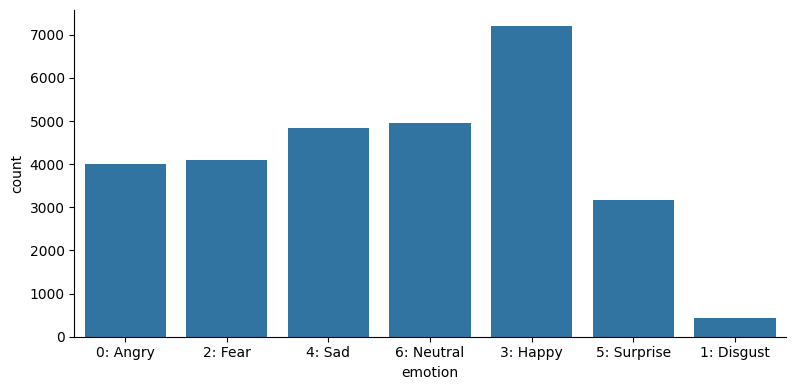

In [3]:
emotionDict = {
    0:'0: Angry',
    1:'1: Disgust',
    2:'2: Fear',
    3:'3: Happy',
    4:'4: Sad',
    5:'5: Surprise',
    6:'6: Neutral'
}

sns.catplot(data=trai_df.replace({'emotion': emotionDict}), kind='count', x='emotion', height=4, aspect=2)

#sns.countplot(x ='emotion', data = trai_df)
plt.show()

We see that there is a data imbalance in our dataset from the histogram above.

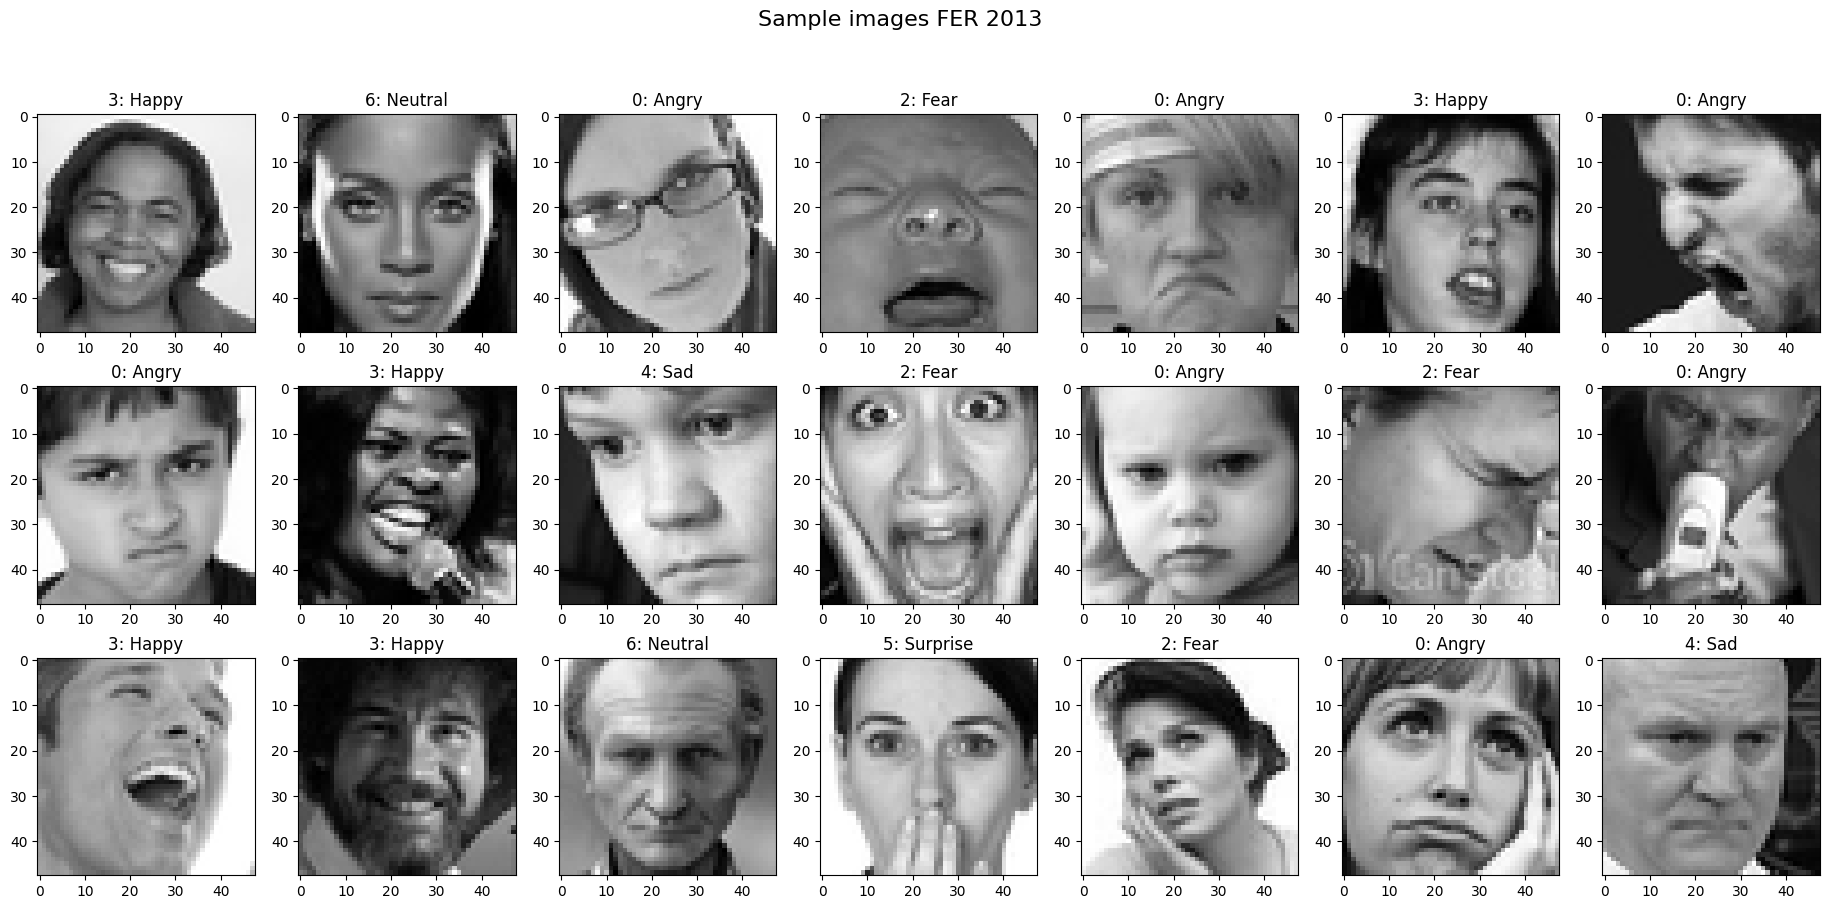

In [4]:
import matplotlib.pyplot as plt

# Now making some plots
random_rows = df.sample(n=21)
imgs = [np.fromstring(pixels, sep=' ').reshape(48, 48) for pixels in random_rows['pixels']]
lbl =  random_rows['emotion'].values

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(23, 10))
fig.suptitle('Sample images FER 2013', fontsize=16)

# Loop through each subplot and customize
for i in range(7):
    for j in range(3):
        ax = axes[j, i]
        ax.imshow(imgs[j*7+i], cmap="gray") 
        ax.set_title('%s'%(emotionDict[lbl[j*7+i]]))
        #ax.grid(True)
plt.show()


As we showcasing random pixtures from our dataset we observe various irregularities such as:

- Missclassification of our picture's emotion to its labels.
- The appearance of watermarks in our images.
- There are cartoon-like pictures of character's faces. 
- The position of the faces in some pictures. For example, there was a woman standing sideways with her mouth open.
- Data set has imbalance between the labels, there are significantly less disgust pictures in the given dataset and significant more happy ones.

All these points will impact the training of our models:

1. Watermarks will affect the features extracted from the images thus later might confuse the model in the training.

2. The watermarks will induce some sort of noise to our training models thus affecting accuracy.

3. The position of the faces in some images might implicate things with feature extraction.

4. Not using real human images for emotion recognision might affect the models when making them predict our emotion during the stage of tracking the user's face via camera.

5. The misslabeling of some images with the wrong emotion might lead to further deteriration of recognizing each emotion.


# Data Preproccessing

## Normalization

In [5]:
from sklearn.preprocessing import MinMaxScaler

def deserialize_image(pixel_str):
    return np.fromstring(pixel_str, sep=' ').reshape(48, 48)

def normalize_image(img):
    scaler = MinMaxScaler()
    img_scaled = scaler.fit_transform(img)
    return img_scaled # scale to [0, 1]


In [6]:
# Load datasets
df_train = pd.read_csv("data/fer2013_train.csv")
df_vali = pd.read_csv("data/fer2013_validation.csv")
df_test = pd.read_csv("data/fer2013_test.csv")

# Normalize the pixel values
X_train_scaled = pd.DataFrame(normalize_image(deserialize_image(p)).flatten() for p in df_train['pixels'])
X_vali_scaled = pd.DataFrame(normalize_image(deserialize_image(p)).flatten() for p in df_vali['pixels'])
X_test_scaled = pd.DataFrame(normalize_image(deserialize_image(p)).flatten() for p in df_test['pixels'])

# Getting the labels for each emotion per set
y_train = df_train['emotion'].values
y_vali = df_vali['emotion'].values
y_test = df_test['emotion'].values


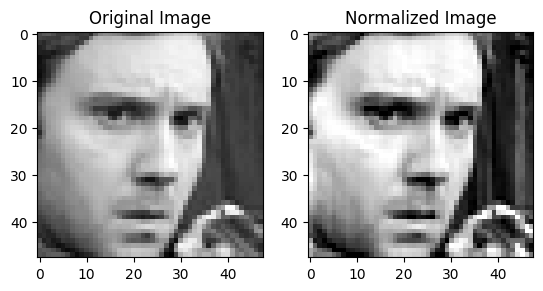

In [7]:
# Example usage:
example_img = np.fromstring(df_train['pixels'].iloc[0], sep=' ').reshape(48, 48) # reshape the pixels to the image space
norm_img = normalize_image(example_img)
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(example_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Normalized Image")
plt.imshow(norm_img, cmap='gray')   
plt.show()

## Data Augmentation

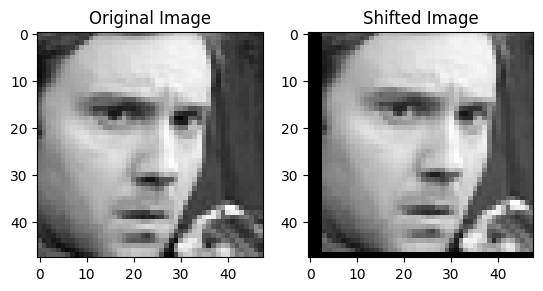

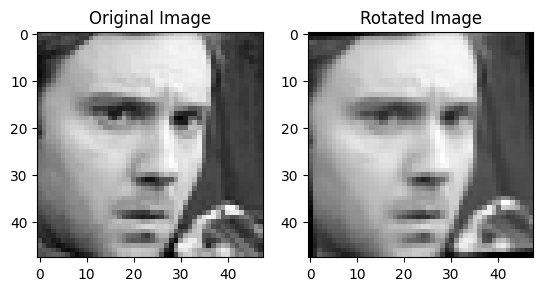

In [8]:
import cv2
import numpy as np

def shift_image(img, x_shift=5, y_shift=5):
    rows, cols = img.shape
    # Create the translation matrix
    x_random_shift = np.random.randint(-x_shift, x_shift)
    y_random_shift = np.random.randint(-y_shift, y_shift)
    translation_matrix = np.float32([[1, 0, x_random_shift], [0, 1, y_random_shift]]) # It moves the picture right for x_shift and down for y_shift
    # Apply the translation to the image
    shifted = cv2.warpAffine(img, translation_matrix, (cols, rows), (rows, cols))
    return shifted


def rotate_image(img, angle=15):
    rows, cols = img.shape
    center_img = (cols // 2, rows // 2)
    random_angle = np.random.uniform(-angle, angle)
    M = cv2.getRotationMatrix2D(center_img, random_angle, 1) # rotates by angle degrees transformation matrix
    rotated = cv2.warpAffine(img, M, (cols, rows))
    return rotated

def data_augmentation(img):
    # Apply random shift
    img = shift_image(img, x_shift=5, y_shift=5)
    # Apply random rotation
    img = rotate_image(img, angle=15)
    return img.flatten()

# Example usage:
example_img = np.fromstring(df_train['pixels'].iloc[0], sep=' ').reshape(48, 48)
shifted_img = shift_image(example_img, x_shift=5, y_shift=5)
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(example_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Shifted Image")
plt.imshow(shifted_img, cmap='gray')   
plt.show()

rotate_img = rotate_image(example_img, angle=15)
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(example_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Rotated Image")
plt.imshow(rotate_img, cmap='gray')   
plt.show()

In [9]:
import numpy as np

# Now we need an function that will perform random oversampling to our targetes minority classes

def random_oversample_minority_class(Xi, yi, minority_label=None, majority_label=None, populus_percentage=0.75):
    """
    Randomily oversample the minority class in a binary classification dataset represented as NumPy arrays.

    Parameters:
    - Xi: dataframe of features in imbalanced dataset
    - yi: dataframe of labels in imbalanced dataset

    Returns:
    - X_rebalanced: numpy array of features after rebalancing
    - y_rebalanced: numpy array of labels after rebalancing
    """
    # Identify indices of the minority class and the other class

    minority_indices = np.where(yi == minority_label)[0]
    majority_indices = np.where(yi == majority_label)[0]
    
    # Calculate number of samples to retain
    
    n_samples = int(populus_percentage*int(len(majority_indices) - len(minority_indices)))
    # print(len(majority_indices) - len(minority_indices))
    # print(n_samples)
    # Oversample with augmentation
    oversampled_images = np.empty((n_samples, 2304), dtype=np.float64)
    oversampled_labels = np.empty((n_samples,), dtype=yi.dtype)

    Xi_img = Xi.values.reshape(-1, 48, 48) # reshape to image for augmentation
    for i in range(n_samples):
        idx = np.random.choice(minority_indices)
        img = Xi_img[idx]
        aug_img = data_augmentation(img) # returns flatten image augmanted
        oversampled_images[i] = aug_img
        oversampled_labels[i] = minority_label
    # print(oversampled_images.shape)

    # Combine with rest of dataset before shuffling

    X_rebalanced = np.concatenate([Xi, np.array(oversampled_images)])
    y_rebalanced = np.concatenate([yi, np.array(oversampled_labels)])

    # Combine indices and shuffle
    combined_indices = np.arange(len(X_rebalanced))
    np.random.seed(42)
    np.random.shuffle(combined_indices)
    # print(X_rebalanced.shape)  # should be (original + augmented, 2304)
    # print(y_rebalanced.shape)  # same number of samples
    # print(X_rebalanced.dtype)  # float32 or float64

    # Return oversampled arrays
    return X_rebalanced[combined_indices], y_rebalanced[combined_indices]

In [10]:
# Lets combat the data imbalance by oversampling the disgust class and surprise class
# We know that fear and disgust are the minority classes, so we will augment them
disgust_class = 1 
surprise_class = 5

# Majority class
happy_class = 3

X_resampled_disgust, y_resampled_disgust = random_oversample_minority_class(
    X_train_scaled,
    y_train, 
    minority_label=disgust_class,
    majority_label=happy_class, 
    populus_percentage=0.7
    )

# Bring it to the FER2013 format
# Create DataFrame from resampled data
df = pd.DataFrame(X_resampled_disgust)
df['emotion'] = y_resampled_disgust

# Serialize pixel values into a single string column
df['pixels'] = df.iloc[:, :-1].apply(lambda row: ' '.join(map(str, row)), axis=1)

# Step 3: Keep only 'emotion' and 'pixels' columns
df_cleaned = df[['emotion', 'pixels']]

In [11]:
# Time to repeat for the surprise class
X_dis = pd.DataFrame(deserialize_image(p).flatten() for p in df_cleaned['pixels'])
y_dis = df_cleaned['emotion'].values
X_resampled_surprise, y_resampled_surprise = random_oversample_minority_class(
    X_dis,
    y_dis, 
    minority_label=surprise_class,
    majority_label=happy_class, 
    populus_percentage=0.7
    )

# Bring it to the FER2013 format
# Create DataFrame from resampled data
df = pd.DataFrame(X_resampled_surprise)
df['emotion'] = y_resampled_surprise

# Serialize pixel values into a single string column
df['pixels'] = df.iloc[:, :-1].apply(lambda row: ' '.join(map(str, row)), axis=1)

# Step 3: Keep only 'emotion' and 'pixels' columns
df_cleaned = df[['emotion', 'pixels']]

In [12]:
# Lets save the new training set
df_cleaned.to_csv("data/fer2013_train_resampled.csv", encoding='utf-8', index=False)

# Feature Engineering

Lets showcase some features of the 21 random picked images.

### Facial Landmarks

In [13]:
import dlib
import cv2

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_landmarks(img):
    faces = detector(img)
    if len(faces) == 0:
        return None
    shape = predictor(img, faces[0])
    return np.array([[p.x, p.y] for p in shape.parts()])

ModuleNotFoundError: No module named 'dlib'

In [ ]:
def draw_landmarks(img, landmarks):
    img_copy = img.copy()
    for (x, y) in landmarks:
        cv2.circle(img_copy, (x, y), 1, (255, 0, 0), -1)
    return img_copy

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(15, 10))
fig.suptitle('Sample images FER 2013 with Facial Landmarks', fontsize=16)

for i in range(7):
    for j in range(3):
        idx = j * 7 + i
        img = imgs[idx]
        landmarks = get_landmarks(img)
        
        ax_orig = axes[j * 2, i]
        ax_orig.imshow(img, cmap='gray')
        ax_orig.set_title(f"Original\n{emotionDict[lbl[idx]]}")
        ax_orig.axis('off')

        ax_landmark = axes[j * 2 + 1, i]
        if landmarks is not None:
            overlay = draw_landmarks(img, landmarks)
            ax_landmark.imshow(overlay, cmap='gray')
        else:
            ax_landmark.imshow(img, cmap='gray')
            ax_landmark.set_title("No face detected")
        ax_landmark.axis('off')

plt.tight_layout()
plt.show()

### HOG:

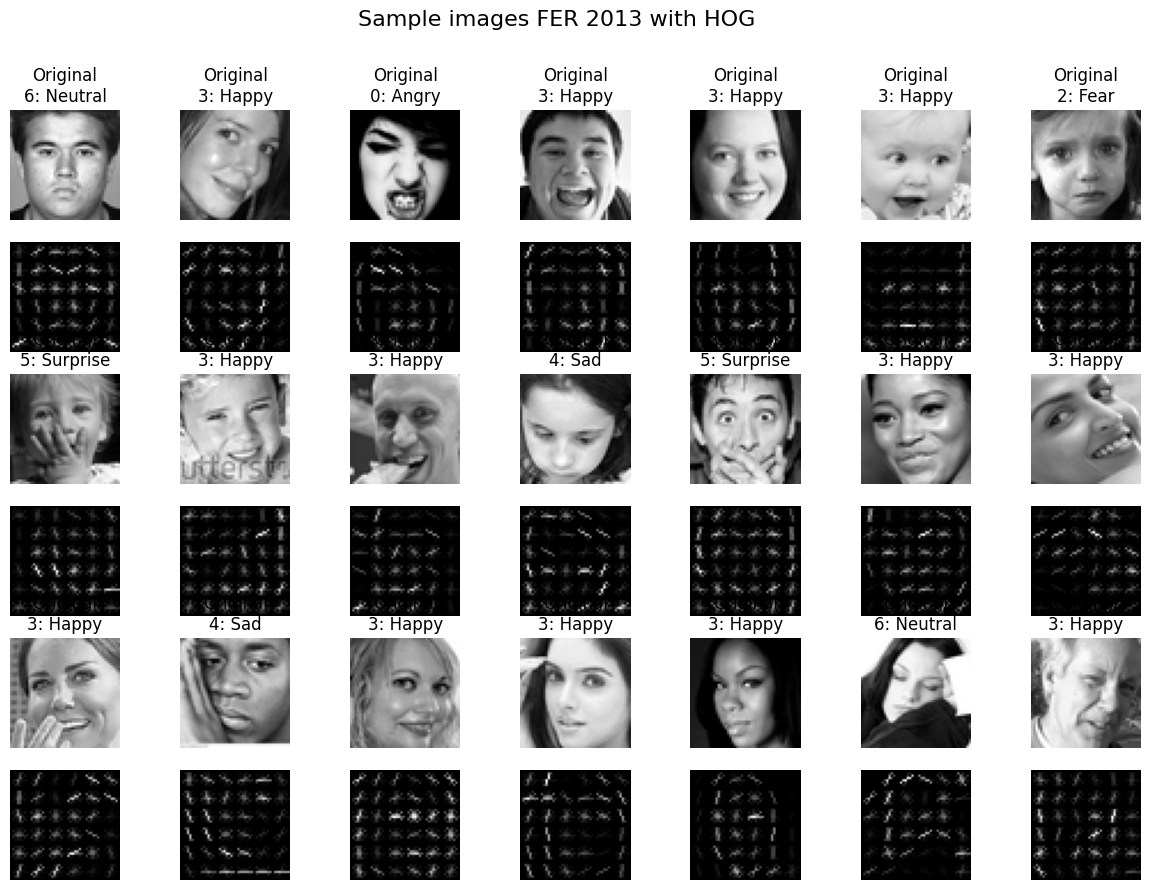

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog

# Images and their HOG transformations 21*2 = 42 images in total
# that is why we need 6 rows 3x2 rows to showcase them all
fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(15, 10)) 
fig.suptitle('Sample images FER 2013 with HOG', fontsize=16)

for i in range(7):
    for j in range(3): # we complete two rows per the second loop completion
        idx = j * 7 + i # index to transverse through all the 21 images 

        # Compute HOG Features
        fd, hog_image = hog(
            imgs[idx],
            orientations = 9,
            pixels_per_cell = (8,8),
            cells_per_block = (2,2),
            visualize = True
		)
        
        # Original
        ax_orig = axes[j * 2, i] 
        ax_orig.imshow(imgs[idx], cmap="gray")
        ax_orig.set_title(f"Original\n{emotionDict[lbl[idx]]}")
        ax_orig.axis('off')

        # Cleaned
        ax_clean = axes[j * 2 + 1, i]
        ax_clean.imshow(hog_image, cmap="gray")
        # ax_clean.set_title("HOG")
        ax_clean.axis('off')

plt.show()

### Eigenfaces/Eigenspaces aka PCA:

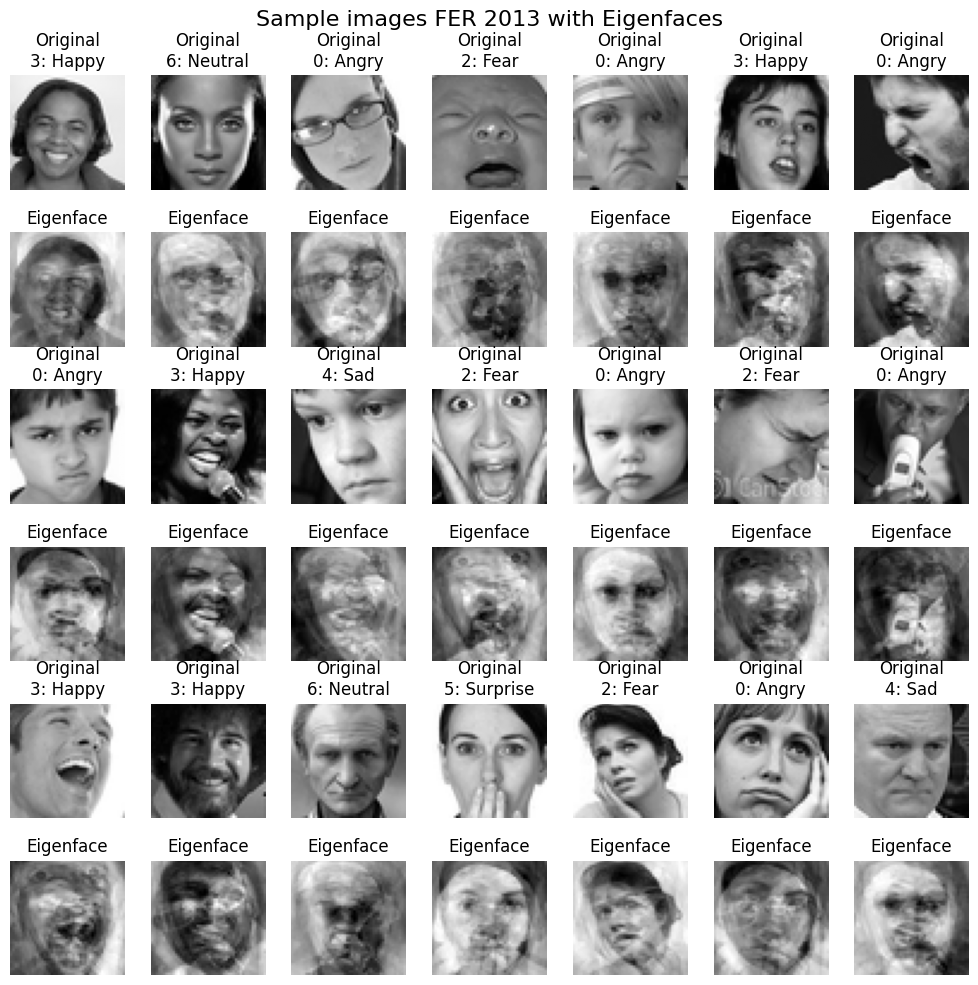

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Flatten and normalize images
X = np.array([img.flatten() for img in imgs])  # imgs = list of 48x48 arrays
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.65)
X_pca = pca.fit_transform(X_scaled)
X_reconstructed = pca.inverse_transform(X_pca)
reconstructed_imgs = X_reconstructed.reshape((-1, 48, 48))

# Plot original images and their corresponding eigenfaces
fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(10, 10))
fig.suptitle('Sample images FER 2013 with Eigenfaces', fontsize=16)

for i in range(7):
    for j in range(3):
        idx = j * 7 + i

        # Original image
        ax_orig = axes[j * 2, i]
        ax_orig.imshow(imgs[idx], cmap="gray")
        ax_orig.set_title(f"Original\n{emotionDict[lbl[idx]]}")
        ax_orig.axis('off')

        # Corresponding eigenface (component)
        ax_eigen = axes[j * 2 + 1, i]
        ax_eigen.imshow(reconstructed_imgs[idx], cmap="gray")
        ax_eigen.set_title("Eigenface")
        ax_eigen.axis('off')

plt.tight_layout()
plt.show()

### Local Binary Patterns (LBP)

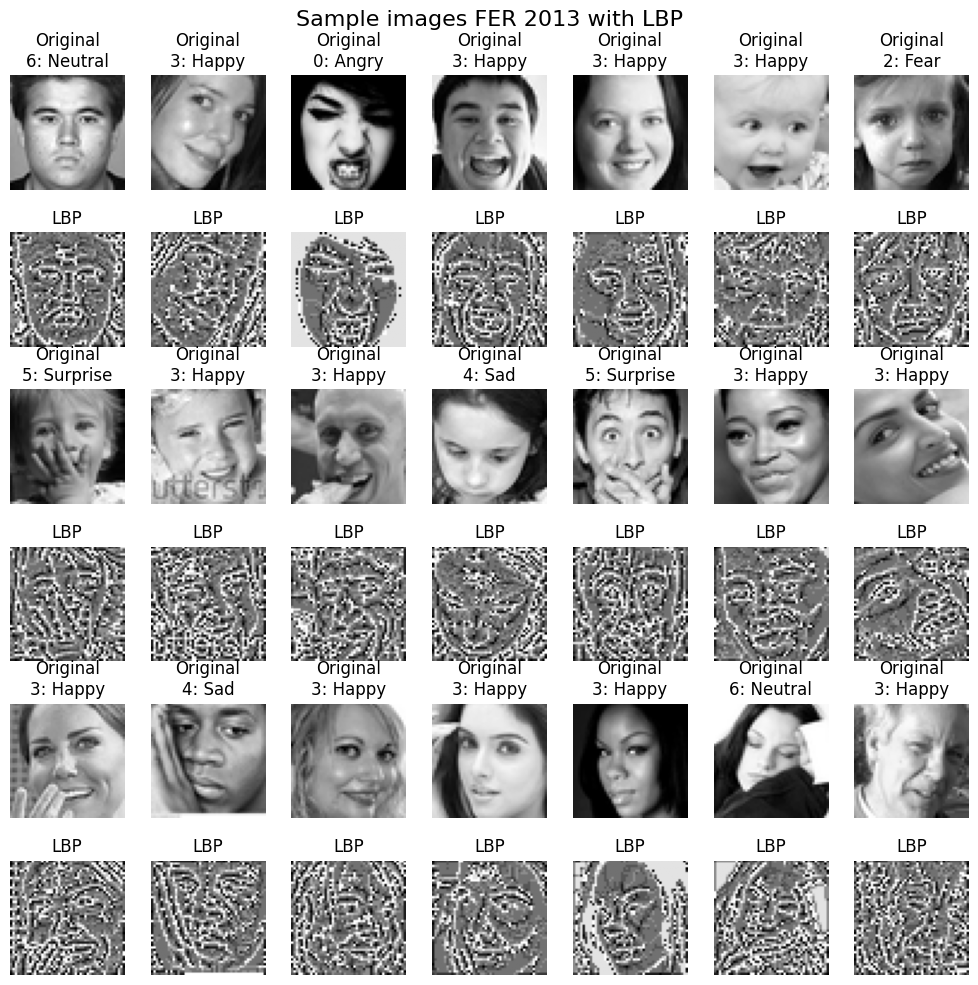

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import numpy as np

# LBP parameters
radius = 1
n_points = 8 * radius
method = 'uniform'

# Create subplot grid: 21 images × 2 rows = 6 rows (3x2) × 7 columns
fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(10, 10))
fig.suptitle('Sample images FER 2013 with LBP', fontsize=16)

for i in range(7):
    for j in range(3):  # 3 pairs of rows
        idx = j * 7 + i  # index for the 21 images

        # Compute LBP
        lbp_image = local_binary_pattern(imgs[idx], n_points, radius, method)

        # Original image
        ax_orig = axes[j * 2, i]
        ax_orig.imshow(imgs[idx], cmap="gray")
        ax_orig.set_title(f"Original\n{emotionDict[lbl[idx]]}")
        ax_orig.axis('off')

        # LBP-transformed image
        ax_lbp = axes[j * 2 + 1, i]
        ax_lbp.imshow(lbp_image, cmap="gray")
        ax_lbp.set_title("LBP")
        ax_lbp.axis('off')

plt.tight_layout()
plt.show()